In [41]:

import numpy as np
import pandas as pd
# %%
import time

import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("a.csv")
import matplotlib.pyplot as plt
import seaborn as sns

FORECASTING TIMESERIES USING LSTM 

In [42]:
df

,datetime_utc,_tempm
0,6/2/2021 0:10,20.94
1,6/2/2021 1:11,20.92
2,6/2/2021 2:10,20.94
3,6/2/2021 3:11,20.92
4,6/2/2021 4:10,23.17
...,...,...
867,7/8/2021 3:10,22.85
868,7/8/2021 4:10,23.10
869,7/8/2021 5:10,23.73
870,7/8/2021 6:10,23.20


In [43]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df = df.set_index('datetime_utc')




In [44]:
df

,_tempm
datetime_utc,
2021-06-02 00:10:00,20.94
2021-06-02 01:11:00,20.92
2021-06-02 02:10:00,20.94
2021-06-02 03:11:00,20.92
2021-06-02 04:10:00,23.17
...,...
2021-07-08 03:10:00,22.85
2021-07-08 04:10:00,23.10
2021-07-08 05:10:00,23.73


In [45]:
df.shape

(872, 1)

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [47]:
df1 = scaler.fit_transform(df)


In [48]:
step = 24
x = []
y = []
for i in range( 0 ,df1.shape[0]-step):
    x.append(df1[i:i+step ])
    y.append(df1[i+step ])

In [49]:
x , y = np.asarray(x) , np.asarray(y)
y = np.reshape(y , (len(y) , 1))

In [50]:
#pd.DataFrame(x).to_csv('append.csv')
#pd.DataFrame(y).to_csv('append1.csv')
y.shape

(848, 1)

In [51]:
x_train , x_test = x[:-24] ,x[-24:]
y_train , y_test= y[:-24] ,y[-24:]


y_test.shape

(24, 1)

In [52]:
x_train = np.reshape(x_train ,  (x_train.shape[0]  , x_train.shape[1]  , 1))
x_test.shape

(24, 24, 1)

In [53]:
from keras.models import Sequential
from keras.layers  import  Dense , Activation , LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

In [54]:
callbacks = EarlyStopping(monitor = "loss", mode = "min", patience = 5, restore_best_weights = True)
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(24,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(24))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x_train , y_train ,epochs=200 , callbacks = callbacks , batch_size=10)


Epoch 1/200
83/83 [==============================] - 11s 66ms/step - loss: 0.0561
Epoch 2/200
83/83 [==============================] - 5s 66ms/step - loss: 0.0124: 0s - 
Epoch 3/200
83/83 [==============================] - 6s 70ms/step - loss: 0.0083
Epoch 4/200
83/83 [==============================] - 5s 64ms/step - loss: 0.0070
Epoch 5/200
83/83 [==============================] - 5s 65ms/step - loss: 0.0057: 0s - loss:
Epoch 6/200
83/83 [==============================] - 5s 65ms/step - loss: 0.0059
Epoch 7/200
83/83 [==============================] - 5s 63ms/step - loss: 0.0062
Epoch 8/200
83/83 [==============================] - 5s 64ms/step - loss: 0.0054
Epoch 9/200
83/83 [==============================] - 5s 63ms/step - loss: 0.0047
Epoch 10/200
83/83 [==============================] - 5s 63ms/step - loss: 0.0060
Epoch 11/200
83/83 [==============================] - 5s 64ms/step - loss: 0.0048
Epoch 12/200
83/83 [==============================] - 5s 63ms/step - loss: 0.0048
Epoch

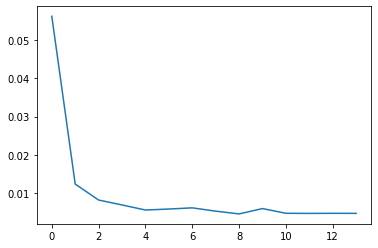

In [55]:

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [56]:

model.save('forecast2.hdf5')

In [57]:
for i in range(0 , x_test.shape[0]):
    temp = []
    x_input = x_test[i,: ,:]
    x_input = np.reshape(x_input , (1,x_input.shape[0] ,1))
    x_input = model.predict(x_input)
    forecast = scaler.inverse_transform(x_input)
    
    y_input = y_test[i,:]
    y_input = np.reshape(y_input , (1,1))
    actual = scaler.inverse_transform(y_input)
    temp.append(actual)
    temp.extend(forecast)
    df_animate = pd.DataFrame(temp)
    df_animate = df_animate.T
    df_animate.to_csv('real time temp.csv' , mode = 'a' ,header= False  , index= False)
    print(temp)
    time.sleep(0.001)
    
    

[array([[23.92]]), array([23.5219], dtype=float32)]
[array([[23.28]]), array([23.610731], dtype=float32)]
[array([[22.91]]), array([23.58566], dtype=float32)]
[array([[22.9]]), array([23.335804], dtype=float32)]
[array([[23.01]]), array([23.117998], dtype=float32)]
[array([[22.61]]), array([22.964867], dtype=float32)]
[array([[22.58]]), array([22.872366], dtype=float32)]
[array([[22.54]]), array([22.784447], dtype=float32)]
[array([[22.35]]), array([22.719498], dtype=float32)]
[array([[22.62]]), array([22.689522], dtype=float32)]
[array([[22.57]]), array([22.675056], dtype=float32)]
[array([[22.53]]), array([22.65015], dtype=float32)]
[array([[22.29]]), array([22.635227], dtype=float32)]
[array([[22.41]]), array([22.647926], dtype=float32)]
[array([[22.24]]), array([22.652374], dtype=float32)]
[array([[22.3]]), array([22.686634], dtype=float32)]
[array([[22.45]]), array([22.687191], dtype=float32)]
[array([[22.41]]), array([22.75467], dtype=float32)]
[array([[22.29]]), array([22.772493

In [58]:
df1 = pd.read_csv('real time temp.csv' , header=None)
df1.columns = ['actual' , 'forecast']
a = np.array(df1['actual'].values.reshape(-1 , 1).tolist())
b =np.array(df1['forecast'].values.reshape(-1 , 1).tolist())
 

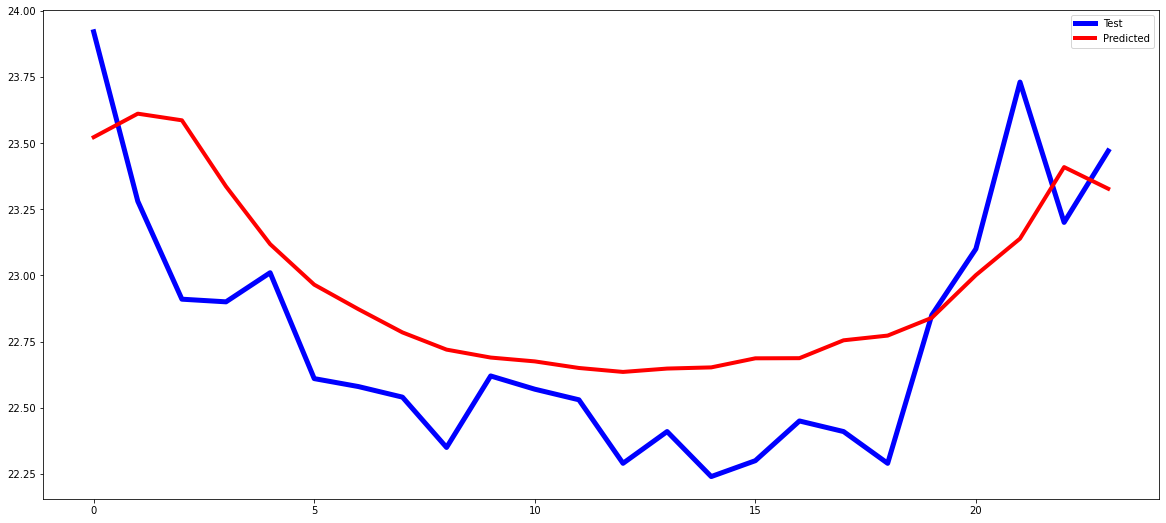

In [59]:
plt.figure(figsize=(20,9))
plt.plot(a , 'blue', linewidth=5)
plt.plot(b,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()